# pupil_new explanation (in detail)

This is a notebook on explaining deeplabcut workflow (**Detailed version**)

Let's import `pupil` first (and datajoint)

In [1]:
import datajoint as dj
from pipeline import pupil

Loading local settings from pipeline_config.json
Connecting donnie@10.28.0.34:3306


/usr/local/lib/python3.6/dist-packages/deeplabcut/__init__.py:22: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/dist-packages/tornado/pla

DLC loaded in light mode; you cannot use the labeling GUI!
DLC loaded in light mode; you cannot use the relabeling GUI!


/usr/local/lib/python3.6/dist-packages/deeplabcut/utils/visualization.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/dist-packages/

OK, now let's see what is under `pupil` module. Simplest way of understanding this module is calling `dj.ERD`

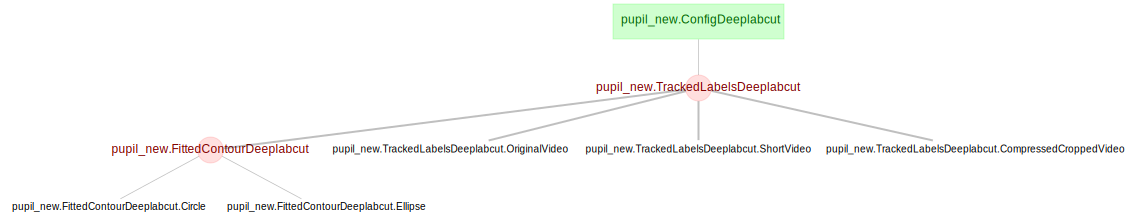

In [2]:
dj.ERD(pupil.schema)

There are 3 particular tables we want to pay attention:
1. ConfigDeeplabcut (dj.Manual)
2. TrackedLabelsDeeplabcut (dj.Computed)
3. FittedContourDeeplabcut (dj.Computed)

let's look at `ConfigDeeplabcut` first

# ConfigDeeplabcut

In [3]:
pupil.ConfigDeeplabcut()

config_path path to deeplabcut config,shuffle shuffle number used for the trained dlc model. Needed for dlc.analyze_videos,trainingsetindex trainingset index used for the trained dlc. model. Needed for dlc.analyze_videos
/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,1,0


In [4]:
pupil.ConfigDeeplabcut.heading

# Minimal info needed to load deeplabcut model
config_path          : varchar(255)                 # path to deeplabcut config
---
shuffle              : smallint unsigned            # shuffle number used for the trained dlc model. Needed for dlc.analyze_videos
trainingsetindex     : smallint unsigned            # trainingset index used for the trained dlc. model. Needed for dlc.analyze_videos

`ConfigDeeplabcut` is a table used to load configuration settings specific to DeepLabCut (DLC) model. Whenever we update our model for some reason (which is going to be Donnie most likely), one needs to ensure that the new `config_path` with appropriate `shuffle` and `trainingsetindex` is provided into this table.

For now, there is only one model (i.e. one model configuration), therefore only 1 entry.

Now let's look at `TrackedLabelsDeeplabcut`

# TrackedLabelDeeplabcut

In [5]:
pupil.TrackedLabelsDeeplabcut()

animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,config_path path to deeplabcut config,tracking_ts automatic,tracking_dir path to tracking directory
20892,9,10,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,2019-04-12 15:10:14,/mnt/scratch06/Two-Photon/taliah/2019-02-07_12-31-03/20892_9_00010_beh_tracking
21608,1,19,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,2019-04-18 20:46:40,/mnt/scratch06/Two-Photon/taliah/2019-04-17_15-13-08/21608_1_00019_beh_tracking


In [6]:
pupil.TrackedLabelsDeeplabcut.heading

# Tracking table using deeplabcut
animal_id            : int                          # id number
session              : smallint                     # session index for the mouse
scan_idx             : smallint                     # number of TIFF stack file
config_path          : varchar(255)                 # path to deeplabcut config
---
tracking_ts=CURRENT_TIMESTAMP : timestamp                    # automatic
tracking_dir         : varchar(255)                 # path to tracking directory

First thing first. `TrackedLabelsDeeplabcut` takes `ConfigDeeplabcut` as a foreign key (as you can see from `dj.ERD`)

Under `TrackedLabelsDeeplabcut`, there are 3 `part tables`

Also, `TrackedLabelsDeeplabcut` is a complex table that performs the following:

1. Given a specific key (i.e. aniaml_id, session, scan_idx), it creates a needed directory structure by calling `create_tracking_directory`.
2. Make a 5 sec long short clip starting from the middle of the _original_ video via `make_short_video`
3. Using DLC model, predict/ find labels on short video via `predict_labels`
4. From the labels on short video, obtain coordinates to be used to _crop_ the original video via `obtain_cropping_coords`
5. Add additional pixels on cropping coordinates via `add_pixels`
6. Using the coordinates from step 4, crop and compress original video via `make_compressed_cropped_video`
7. Predict on `compressed_cropped_video`

I know it is alot to digest, so let's look at it one by one

## 1. Given a specific key (i.e. aniaml_id, session, scan_idx), it creates a needed directory structure by calling `create_tracking_directory`.

Let's call `create_tracking_directory?` and see what that does

In [7]:
pupil.TrackedLabelsDeeplabcut.create_tracking_directory?

Signature: pupil_new.TrackedLabelsDeeplabcut.create_tracking_directory(self, key)
Docstring:
this function creates the following directory structure:

video_original_dir
    |
    |------ video_original
    |------ tracking_dir (create_tracking_directory)
                |------- symlink to video_original (add_symlink) 
                |------- compressed_cropped_dir
                            |------- cropped_video (generated by make_compressed_cropped_video function)
                            |------- h5 file for cropped video (generated by deeplabcut)
                            |------- pickle for cropped video (generated by deeplabcut)
                |------- short_dir
                            |------- short_video (generated by make_short_video function)
                            |------- h5 file for short video(generated by deeplabcut)
                            |------- pickle for short video (generated by deeplabcut)

Input:
    key: dictionary
        a dictionary th

Basically, given a specific video, it creates a tracking directory, add a symlink to the original video inside the tracking directory. Then it creates 2 sub direcotories, `short` and `compressed_cropped`. The reason we make such hierarchy is that 
1. we want to compress the video (not over time but only over space) such that we reduce the size of the video while DLC can still predict reliably 
2. we do not want to predict on the entire video, but only around the pupil area, hence we need to crop 
3. In order to crop, we need to know where the pupil is, hence make a 5 sec long (or short video). Then using DLC model, find appropriate cropping coordinates.


One can actually see a real example by looking at case `20892_10_10`, one of the entires in the table

In [8]:
# Uncomment this cell to see

import os
key = dict(animal_id = 20892, session=10, scan_idx=10)
tracking_dir = (pupil_new.TrackedLabelsDeeplabcut & key).fetch1('tracking_dir')
print(os.listdir(tracking_dir))
print(os.listdir(os.path.join(tracking_dir, 'short')))
print(os.listdir(os.path.join(tracking_dir, 'compressed_cropped')))

['20892_9_00010_beh.avi', 'compressed_cropped', 'short']
['20892_9_00010_beh_shortDeepCut_resnet50_pupil_trackFeb12shuffle1_600000includingmetadata.pickle', '20892_9_00010_beh_short.avi', '20892_9_00010_beh_shortDeepCut_resnet50_pupil_trackFeb12shuffle1_600000.h5']
['20892_9_00010_beh_compressed_cropped.avi', '20892_9_00010_beh_compressed_croppedDeepCut_resnet50_pupil_trackFeb12shuffle1_600000includingmetadata.pickle', '20892_9_00010_beh_compressed_croppedDeepCut_resnet50_pupil_trackFeb12shuffle1_600000.h5']


.pickle and .h5 files are generated by DLC model and are used to predict labels. We will talk about it very soon, but for now, notice that under `tracking_dir`, we have the behavior video, `20892_9_10_beh.avi`. This is, however, _only_ a symlink to the actual video. Hence, even if we accidentally delete it, no harm to the actual video itself :) 

Also, some `original video` info are saved in the part table, `OriginalVideo`. I think both the primary and secondary keys are self-explantory

In [9]:
pupil.TrackedLabelsDeeplabcut.OriginalVideo()

animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,config_path path to deeplabcut config,original_width original video width size,original_height original video height size,video_path path to original video
20892,9,10,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,664,672,/mnt/scratch06/Two-Photon/taliah/2019-02-07_12-31-03/20892_9_00010_beh_tracking/20892_9_00010_beh.avi
21608,1,19,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,954,648,/mnt/scratch06/Two-Photon/taliah/2019-04-17_15-13-08/21608_1_00019_beh_tracking/21608_1_00019_beh.avi


## 2. Make a 5 sec long short clip starting from the middle of the _original_ video via `make_short_video`

In [10]:
pupil.TrackedLabelsDeeplabcut.make_short_video?

Signature: pupil_new.TrackedLabelsDeeplabcut.make_short_video(self, tracking_dir)
Docstring:
Extract 5 seconds long video starting from the middle of the original video.

Input:
    tracking_dir: string
        String that specifies the full path of tracking directory
Return:
    None
File:      /data/pipeline/python/pipeline/pupil_new.py
Type:      function


This function is quite straightforward. Using the symlink, we access the original video, then find the middle frame, which then is converted into actual time (in format of hr:min:sec). Then, using ffmpeg, we extract 5 second long video and save it under `short` directory.

For `ShortVideo` `part table`, it saves both the path to the short video (`video_path`) and `starting_frame`. `starting_frame` indicates the middle frame number of the original video.

In [11]:
pupil.TrackedLabelsDeeplabcut.ShortVideo()

animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,config_path path to deeplabcut config,starting_frame middle frame of the original video,video_path path to short video
20892,9,10,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,61769,/mnt/scratch06/Two-Photon/taliah/2019-02-07_12-31-03/20892_9_00010_beh_tracking/short/20892_9_00010_beh_short.avi
21608,1,19,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,66595,/mnt/scratch06/Two-Photon/taliah/2019-04-17_15-13-08/21608_1_00019_beh_tracking/short/21608_1_00019_beh_short.avi


## 3. Using DLC model, predict/ find labels on _short video_ via `predict_labels`

In [12]:
pupil.TrackedLabelsDeeplabcut.predict_labels?

Signature: pupil_new.TrackedLabelsDeeplabcut.predict_labels(self, vid_path, config)
Docstring:
Predict labels on a given video

Input:
    vid_path: string
        Path to video.
    config: dictionary
        a deeplabcut model configuration dictionary.
File:      /data/pipeline/python/pipeline/pupil_new.py
Type:      function


Using DLC model, we predict on short video that was made from `step 2`. Quite straightforward here.

## 4. From the labels on short video, obtain coordinates to be used to _crop_ the original video via `obtain_cropping_coords`

In [13]:
pupil.TrackedLabelsDeeplabcut.obtain_cropping_coords?

Signature:
pupil_new.TrackedLabelsDeeplabcut.obtain_cropping_coords(
    self,
    short_h5_path,
    DLCscorer,
    config,
)
Docstring:
First, filter out by the pcutoff, then find values that are within 1 std from mean 
for each eyelid bodypart. Then, compare among the parts and find min,max values in x and y.

The reason we use 1 std from mean is that dlc might have outliers in this short video.
Hence we filter out these potential outliers

Input: 
    short_h5_path: string
        path to h5 file generated by deeplabcut on short video.
    DLCscorer: string
        scorer name used for deeplabcut. Can be obtained via auxiliaryfunctions.GetScorerName(config, shuffle, trainsetindex)
    config: dictionary
        a deeplabcut model configuration dictionary.
File:      /data/pipeline/python/pipeline/pupil_new.py
Type:      function


To fully understand what is going on here, a bit of backgound on deeplabcut (DLC) is needed. When DLC predicts a label, it returns a likelihood of a label (value between 0 and 1.0). Here, I used 0.9 as a threshold to filter out whether the predicted label is accurate or not. 

For example, we can take a quick look on how DLC predicted on short video clip

In [14]:
import pandas as pd
df_short = pd.read_hdf(os.path.join(tracking_dir,'short', '20892_10_00010_beh_shortDeepCut_resnet50_pupil_trackFeb12shuffle1_600000.h5'))
df_short.head()

scorer    DeepCut_resnet50_pupil_trackFeb12shuffle1_600000              \
bodyparts                                       eyelid_top               
coords                                                   x           y   
0                                               534.425725  427.513941   
1                                               533.824994  432.140399   
2                                               532.629066  429.682028   
3                                               535.210389  433.443434   
4                                               531.299866  431.620190   

scorer                                                                     \
bodyparts            eyelid_top_right                        eyelid_right   
coords    likelihood                x           y likelihood            x   
0           0.998007       601.111538  450.070927   0.997492   640.465158   
1           0.998947       600.167688  450.306261   0.997769   640.316483   
2           0.996824       600.631613  452.142071   0.997543   639.192039   
3           0.999348       599.978720  451.426211   0.996986   640.386463   
4           0.998612       601.320297  449.745562   0.996894   640.258167   

scorer                                                ...               \
bodyparts                        eyelid_right_bottom  ... pupil_bottom   
coords              y likelihood                   x  ...   likelihood   
0          482.741327   0.998835          610.109566  ...     0.996490   
1          482.195057   0.997401          611.357602  ...     0.997342   
2          481.948817   0.998141          606.598782  ...     0.996192   
3          483.596053   0.998900          612.032993  ...     0.998209   
4          481.549078   0.997049          609.257354  ...     0.995877   

scorer                                                                      \
bodyparts pupil_bottom_left                         pupil_left               
coords                    x           y likelihood           x           y   
0                509.575130  584.961421   0.998317  490.955374  551.112065   
1                507.673664  582.453534   0.999121  490.159025  547.781012   
2                509.549948  583.773397   0.998460  490.177911  551.282620   
3                507.670039  582.878125   0.998154  490.339835  547.163250   
4                508.865447  583.167753   0.998073  490.184886  549.955343   

scorer                                                      
bodyparts            pupil_left_top                         
coords    likelihood              x           y likelihood  
0           0.999637     504.742994  516.772419   0.999491  
1           0.999845     505.865031  514.827630   0.999466  
2           0.999516     504.109388  516.285706   0.999440  
3           0.999765     505.759629  513.809211   0.999474  
4           0.999733     503.730835  515.531684   0.999554  

[5 rows x 48 columns]

0.90 is probably more than good enough given how confident DLC thinks about the locations of bodyparts.

But sometimes, as any DL models, DLC _can_ predict at somewhere completely wrong with _high_ confidence. To filter those _potential outliers_, we only retain values within 1 std. from mean. Then, we find `min` and `max` values in `x` and `y` coordinates from 5 second long video.

Btw, we only look at the `eyelid_top`, `eyelid_bottom`, `eyelid_left`, `eyelid_right` as they are, in theory, extremes of the bounding box to draw.

## 5. Add additional pixels on cropping coordinates via `add_pixels`

In [15]:
pupil.TrackedLabelsDeeplabcut.add_pixels?

Signature:
pupil_new.TrackedLabelsDeeplabcut.add_pixels(
    self,
    cropped_coords,
    original_width,
    original_height,
    pixel_num,
)
Docstring:
Add addtional pixels around cropped_coords
Input:
    cropped_coords: dictionary
        cropoping coordinates specifying left_top  and bottom_right coords
    original_width: int
        width of the original video
    original_height: int
        height of the original video
    pixel_num: int
        number of pixels to add around the cropped_coords
Return:
    cropped_coords: dictionary
        updated cropoping coordinates specifying left_top  and bottom_right coords
File:      /data/pipeline/python/pipeline/pupil_new.py
Type:      function


Now that we have coords to crop around, we add addtional pixels (**100** specifically) on top. 

In my experience, 100 pixels were enough to ensure that even in drastic eyelid movements (i.e. eyes being super wide open), all the body parts are within the cropping coordinates.

## 6. Using the coordinates from step 5, crop and compress original video via `make_compressed_cropped_video`

In [16]:
pupil.TrackedLabelsDeeplabcut.make_compressed_cropped_video?

Signature:
pupil_new.TrackedLabelsDeeplabcut.make_compressed_cropped_video(
    self,
    tracking_dir,
    cropped_coords,
)
Docstring:
Make a compressed and cropped video.

Input:
    tracking_dir: string
        String that specifies the full path of tracking directory
    cropped_coords: dictionary 
        cropoping coordinates specifying left_top  and bottom_right coords
Return:
    None
File:      /data/pipeline/python/pipeline/pupil_new.py
Type:      function


Using cropping coordinates from step 5, we compress and crop the original video via `ffmpeg` and save it under `compressed_cropped` directory. This takes around 15-25 minutes.

In `CompressedCroppedVideo` part table, one can see the cropping coords (after adding `added_pixels`), how many pixels added, and `video_path` to `compressed_cropped video`

In [17]:
pupil.TrackedLabelsDeeplabcut.CompressedCroppedVideo()

animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,config_path path to deeplabcut config,cropped_x0 start width coord wrt original video,cropped_x1 end width coord wrt original video,cropped_y0 start height coord wrt original video,cropped_y1 end height coord wrt original video,added_pixels number of pixels added around the cropping coords,video_path path to comparessed & cropped video
20892,9,10,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,330,664,329,672,100,/mnt/scratch06/Two-Photon/taliah/2019-02-07_12-31-03/20892_9_00010_beh_tracking/compressed_cropped/20892_9_00010_beh_compressed_cropped.avi
21608,1,19,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,600,954,326,648,100,/mnt/scratch06/Two-Photon/taliah/2019-04-17_15-13-08/21608_1_00019_beh_tracking/compressed_cropped/21608_1_00019_beh_compressed_cropped.avi


## 7. Predict on `compressed_cropped_video`

In [18]:
pupil.TrackedLabelsDeeplabcut.predict_labels?

Signature: pupil_new.TrackedLabelsDeeplabcut.predict_labels(self, vid_path, config)
Docstring:
Predict labels on a given video

Input:
    vid_path: string
        Path to video.
    config: dictionary
        a deeplabcut model configuration dictionary.
File:      /data/pipeline/python/pipeline/pupil_new.py
Type:      function


Same as `step 3`, but this time, using `cropped_compressed` video. **MAKE SURE YOU HAVE GPU AVAILABLE.** Otherwise, this will take significantly long time. With GPU enabled, this takes around 20-40 minutes.

# FittedContourDeeplabcut

Now that we have a tracked labels, now it is time to fit. Here, we fit both a **circle** and and **ellipse**.

In [19]:
pupil.FittedContourDeeplabcut()

animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,config_path path to deeplabcut config,fitting_ts automatic
20892,9,10,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,2019-04-16 15:35:22
21608,1,19,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,2019-04-18 23:35:34


## Circle

In [20]:
print(key)
(pupil.FittedContourDeeplabcut & key).Circle.heading

{'animal_id': 20892, 'session': 9, 'scan_idx': 10}


# 
animal_id            : int                          # id number
session              : smallint                     # session index for the mouse
scan_idx             : smallint                     # number of TIFF stack file
config_path          : varchar(255)                 # path to deeplabcut config
frame_id             : int                          # frame id with matlab based 1 indexing
---
center=null          : tinyblob                     # center of the circle in (x, y) of image
radius=null          : float                        # radius of the circle
visible_portion=null : float                        # portion of visible pupil area given a fitted circle frame. Please refer DLC_tools.PupilFitting.detect_visible_pupil_area for more details

In [21]:
(pupil.FittedContourDeeplabcut & key).Circle() 

animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,config_path path to deeplabcut config,frame_id frame id with matlab based 1 indexing,"center center of the circle in (x, y) of image",radius radius of the circle,visible_portion portion of visible pupil area given a fitted circle frame. Please refer DLC_tools.PupilFitting.detect_visible_pupil_area for more details
20892,9,10,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,0,=BLOB=,nan,-3.0
20892,9,10,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,1,=BLOB=,nan,-3.0
20892,9,10,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,2,=BLOB=,nan,-3.0
20892,9,10,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,3,=BLOB=,nan,-3.0
20892,9,10,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,4,=BLOB=,nan,-3.0
20892,9,10,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,5,=BLOB=,nan,-3.0
20892,9,10,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,6,=BLOB=,nan,-3.0
20892,9,10,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,7,=BLOB=,nan,-3.0
20892,9,10,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,8,=BLOB=,nan,-3.0
20892,9,10,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,9,=BLOB=,nan,-3.0


For circle, we save `center` coordinates in a tuple format, `radius` in float, and `visible_portion` in float. `visible_portion` is defined as the following: Given a fitted `circle` or an `ellipse`, subtract the area that is occuluded by `eyelids`, and return the portion of _visible_ pupil area w.r.t. the _fitted_ area. In theory, the value ranges from 0 (pupil is completely _invisible_) to 1 (pupil is completely _visible_). However there are cases where visible portion cannot be calculated:

1. DLC failed to predict **all** eyelid labels, hence _visible_ region cannot be obtained (evaluated to -1)
2. Because the number of predicted pupil labels are less than 3 for `circle` (and 6 for `ellipse`), fitting did **not** happen. Hence we do not know the area of the pupil as well as _visible_ region (evaluated to -2)
3. Both case 1 and 2 happened (evaluated to -3)

In the beginning of the videos, we have black screens, hence both eyelids and pupil labels are not predicted, which evaluated to -3.

As `visible_portion` comment indicates, one can find the same information from `DLC_tools.PupilFitting.detect_visible_pupil_area`

In [22]:
from pipeline.utils import DLC_tools
DLC_tools.PupilFitting.detect_visible_pupil_area?

Signature:
DLC_tools.PupilFitting.detect_visible_pupil_area(
    self,
    eyelid_connect_dict,
    fit_dict,
    fitting_method=None,
)
Docstring:
Given a frame, find a visible part of the pupil by finding the intersection of pupil and eyelid masks
If pupil mask does not exist(i.e. label < 3), return None

Input:
    eyelid_connect_dict: dicionary
        An output dictionary from method 'connect_eyelids'
    fit_dict: dictionary
        An output dictionary from either of the method 'fit_circle_to_pupil' or 'fit_ellipse_to_pupil'
    fitting_method: string
        A string indicates whether the fitted method was an 'ellipse' or a 'circle'. 

Output:
    A dictionary that contains the following:
        mask: numpy array
            A 3D mask that depicts visible area of pupil. 
            If no visible area provided, then it is an np.zeros
        visible_portion: signed float
            if visible area exists, then value ranges from 0.0 to 1.0
            if equal to -1.0, not all

Ellipse table is very similar to that of a circle table

## Ellipse

In [23]:
print(key)
(pupil.FittedContourDeeplabcut & key).Ellipse.heading

{'animal_id': 20892, 'session': 9, 'scan_idx': 10}


# 
animal_id            : int                          # id number
session              : smallint                     # session index for the mouse
scan_idx             : smallint                     # number of TIFF stack file
config_path          : varchar(255)                 # path to deeplabcut config
frame_id             : int                          # frame id with matlab based 1 indexing
---
center=null          : tinyblob                     # center of the ellipse in (x, y) of image
major_radius=null    : float                        # major radius of the ellipse
minor_radius=null    : float                        # minor radius of the ellipse
rotation_angle=null  : float                        # ellipse rotation angle in degrees w.r.t. major_radius
visible_portion=null : float                        # portion of visible pupil area given a fitted ellipse frame. Please refer DLC_tools.PupilFitting.detect_visible_pupil_area for more details

In [24]:
(pupil.FittedContourDeeplabcut & key).Ellipse() 

animal_id id number,session session index for the mouse,scan_idx number of TIFF stack file,config_path path to deeplabcut config,frame_id frame id with matlab based 1 indexing,"center center of the ellipse in (x, y) of image",major_radius major radius of the ellipse,minor_radius minor radius of the ellipse,rotation_angle ellipse rotation angle in degrees w.r.t. major_radius,visible_portion portion of visible pupil area given a fitted ellipse frame. Please refer DLC_tools.PupilFitting.detect_visible_pupil_area for more details
20892,9,10,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,0,=BLOB=,nan,nan,nan,-3.0
20892,9,10,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,1,=BLOB=,nan,nan,nan,-3.0
20892,9,10,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,2,=BLOB=,nan,nan,nan,-3.0
20892,9,10,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,3,=BLOB=,nan,nan,nan,-3.0
20892,9,10,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,4,=BLOB=,nan,nan,nan,-3.0
20892,9,10,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,5,=BLOB=,nan,nan,nan,-3.0
20892,9,10,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,6,=BLOB=,nan,nan,nan,-3.0
20892,9,10,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,7,=BLOB=,nan,nan,nan,-3.0
20892,9,10,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,8,=BLOB=,nan,nan,nan,-3.0
20892,9,10,/mnt/scratch07/donnie/DeepLabCut/pupil_track-Donnie-2019-02-12/config.yaml,9,=BLOB=,nan,nan,nan,-3.0


That's it for now!

The `Fitting` process can take up to **1.5~2 hrs** (assuming Fitting process is the only thing that is running on the machine).